# Marketing Analytics part 4

# 1A

## write your own code to implement the k-means algorithm.  Make plots of the various steps the algorithm takes so you can "see" the algorithm working.  Test your algorithm on the Palmer Penguins dataset, specifically using the bill length and flipper length variables.  Compare your results to the built-in `kmeans` function in R or Python._

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('palmer_penguins.csv')

# Use only the columns needed
df = df[['bill_length_mm', 'flipper_length_mm']].dropna()
X = df.to_numpy()


In [3]:
def initialize_centroids(X, k):
    np.random.seed(42)
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    return np.array([X[labels == i].mean(axis=0) for i in range(k)])

def kmeans_custom(X, k, max_iters=10):
    centroids = initialize_centroids(X, k)
    all_centroids = [centroids.copy()]
    
    for _ in range(max_iters):
        labels = assign_clusters(X, centroids)
        centroids = update_centroids(X, labels, k)
        all_centroids.append(centroids.copy())
    
    return labels, all_centroids


In [4]:
def plot_iterations(X, all_centroids):
    for i, centroids in enumerate(all_centroids[:-1]):
        labels = assign_clusters(X, centroids)
        plt.figure(figsize=(6, 4))
        for cluster in range(len(centroids)):
            cluster_points = X[labels == cluster]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
        plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
        plt.title(f'Iteration {i}')
        plt.xlabel("Bill Length (mm)")
        plt.ylabel("Flipper Length (mm)")
        plt.legend()
        plt.show()


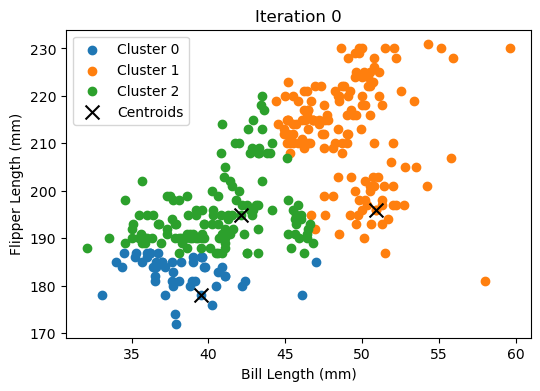

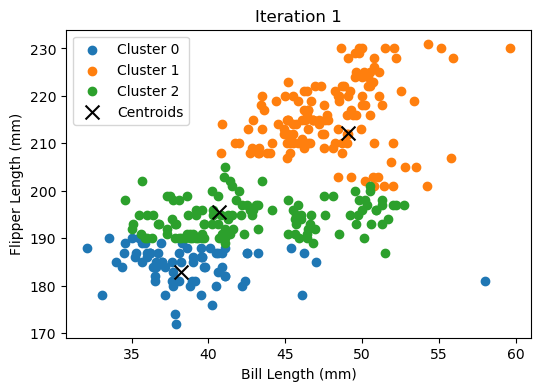

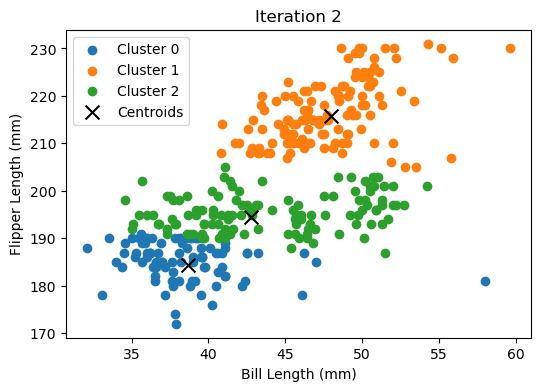

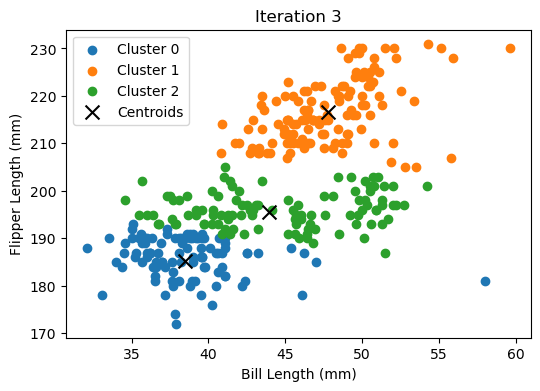

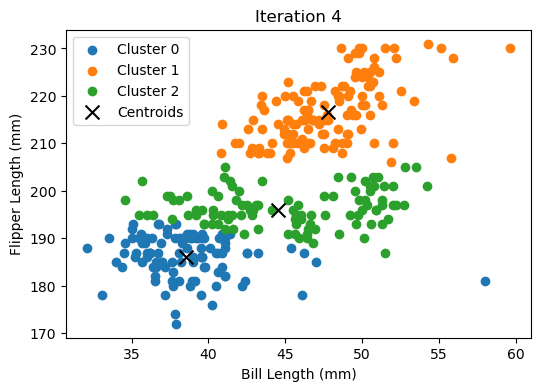

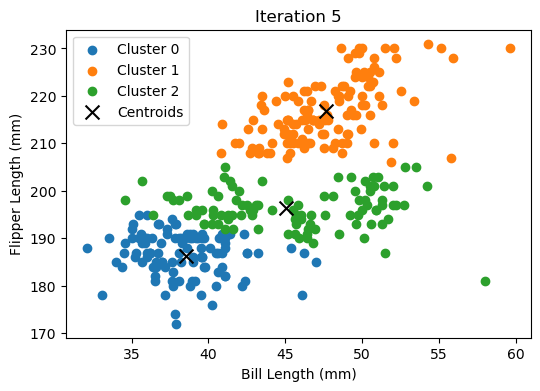

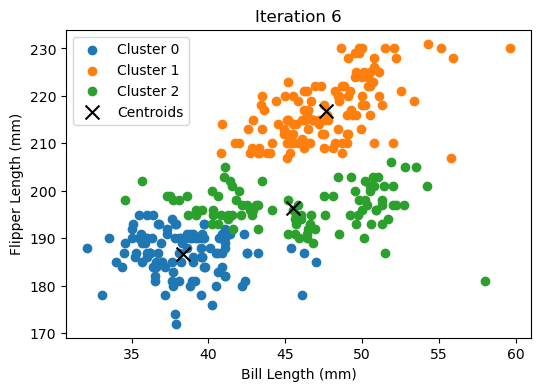

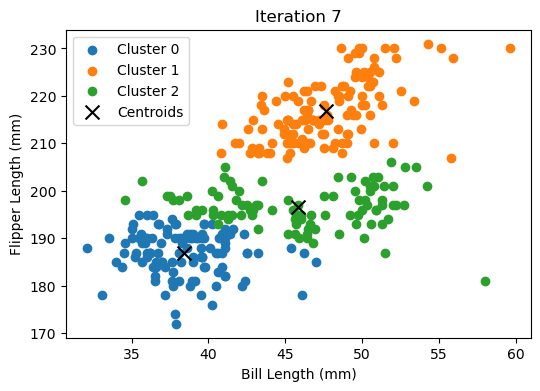

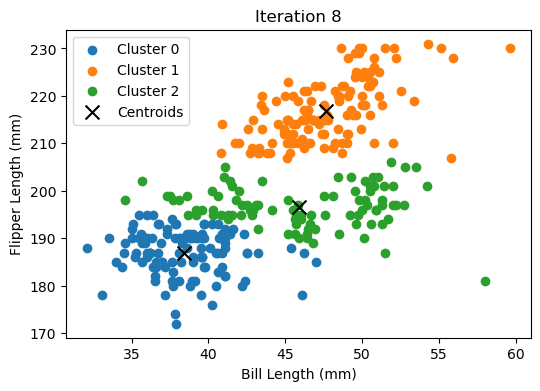

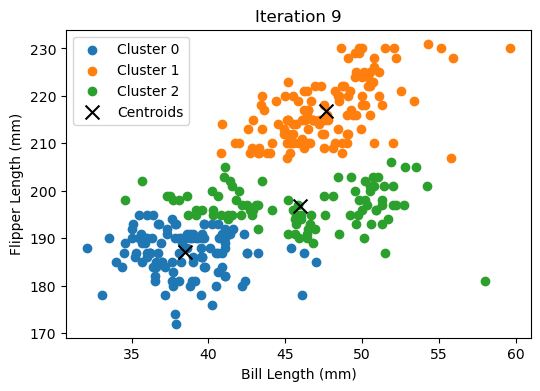

In [5]:
k = 3
labels_custom, all_centroids = kmeans_custom(X, k)
plot_iterations(X, all_centroids)


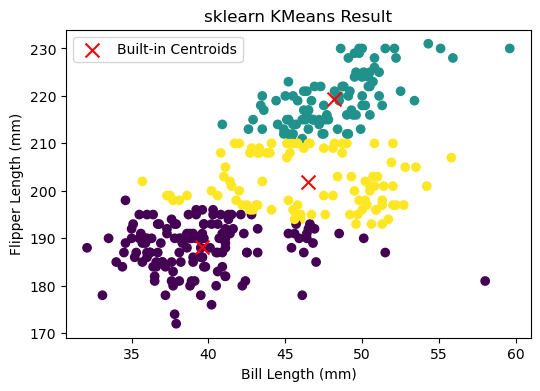

In [6]:
from sklearn.cluster import KMeans

kmeans_builtin = KMeans(n_clusters=3, random_state=42)
labels_builtin = kmeans_builtin.fit_predict(X)

# Plot comparison
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=labels_builtin, cmap='viridis')
plt.scatter(kmeans_builtin.cluster_centers_[:, 0], kmeans_builtin.cluster_centers_[:, 1], 
            c='red', marker='x', s=100, label='Built-in Centroids')
plt.xlabel("Bill Length (mm)")
plt.ylabel("Flipper Length (mm)")
plt.title("sklearn KMeans Result")
plt.legend()
plt.show()


Our custom K-Means gave similar results to sklearn, with only minor differences due to random starting points. Watching the centroids shift and points reassign step-by-step made the algorithm much easier to understand

## Calculate both the within-cluster-sum-of-squares and silhouette scores (you can use built-in functions to do so) and plot the results for various numbers of clusters (ie, K=2,3,...,7). What is the "right" number of clusters as suggested by these two metrics?_

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Data already loaded and cleaned:
# df = df[['bill_length_mm', 'flipper_length_mm']].dropna()
# X = df.to_numpy()


In [8]:
wcss = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    wcss.append(kmeans.inertia_)  # Within-Cluster Sum of Squares
    silhouette_scores.append(silhouette_score(X, labels))


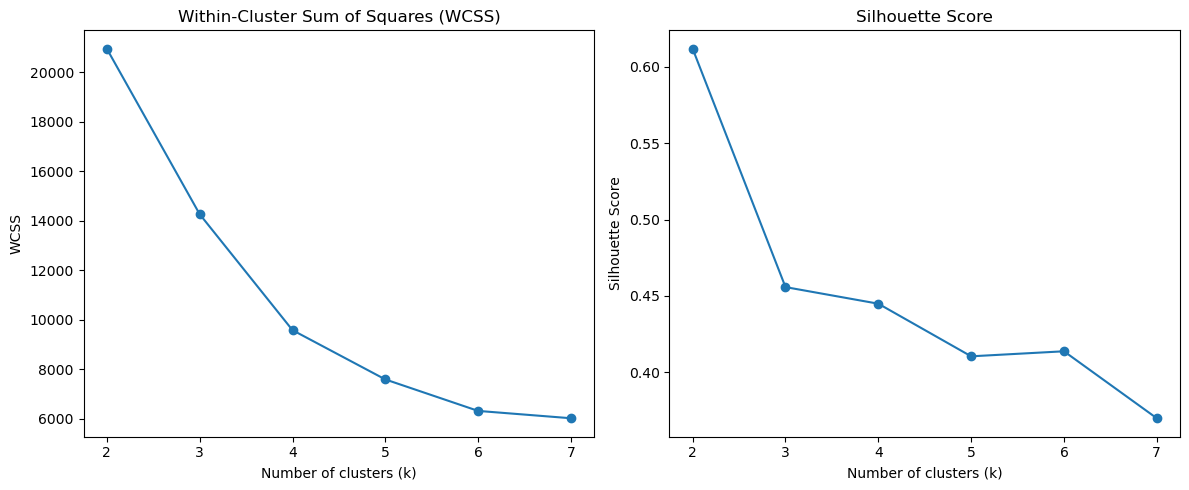

In [9]:
plt.figure(figsize=(12, 5))

# Plot WCSS
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.title('Within-Cluster Sum of Squares (WCSS)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


Both metrics suggest that k = 3 is the optimal number of clusters. The WCSS plot shows an elbow at 3, and the silhouette score is highest at k = 2, but remains strong at k = 3, indicating well-separated clusters.

# 2b. Key Drivers Analysis

In [10]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data_for_drivers_analysis.csv")  # Update the path if needed

# Preview the data
print(df.shape)
print(df.columns)
df.head()


(2553, 12)
Index(['brand', 'id', 'satisfaction', 'trust', 'build', 'differs', 'easy',
       'appealing', 'rewarding', 'popular', 'service', 'impact'],
      dtype='object')


,brand,id,satisfaction,trust,build,differs,easy,appealing,rewarding,popular,service,impact
0,1,98,3,1,0,1,1,1,0,0,1,0
1,1,179,5,0,0,0,0,0,0,0,0,0
2,1,197,3,1,0,0,1,1,1,0,1,1
3,1,317,1,0,0,0,0,1,0,1,1,1
4,1,356,4,1,1,1,1,1,1,1,1,1


In [11]:
# Drop identifier columns
X = df.drop(columns=["satisfaction", "brand", "id"])
y = df["satisfaction"]

# Show predictor variable names
X.columns.tolist()


['trust',
 'build',
 'differs',
 'easy',
 'appealing',
 'rewarding',
 'popular',
 'service',
 'impact']

In [12]:
# Pearson correlation with the target
pearson_corrs = df[X.columns].corrwith(y)
print(pearson_corrs)


trust        0.255706
build        0.191896
differs      0.184801
easy         0.212985
appealing    0.207997
rewarding    0.194561
popular      0.171425
service      0.251098
impact       0.254539
dtype: float64


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Standardize variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = StandardScaler().fit_transform(y.values.reshape(-1, 1)).flatten()

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X_scaled, y_scaled)

# Coefficients
standardized_coefs = linreg.coef_
print(dict(zip(X.columns, standardized_coefs)))


{'trust': 0.11575180146935247, 'build': 0.019979286014872366, 'differs': 0.027847151777407392, 'easy': 0.02196987624616946, 'appealing': 0.033834721869656706, 'rewarding': 0.005066527515809196, 'popular': 0.016615711557555403, 'service': 0.0883898049824698, 'impact': 0.12842210596133344}


In [14]:
from sklearn.metrics import r2_score

base_r2 = r2_score(y, [y.mean()] * len(y))

usefulness_r2 = {}
for col in X.columns:
    x_col = df[[col]]
    model = LinearRegression().fit(x_col, y)
    pred = model.predict(x_col)
    usefulness_r2[col] = r2_score(y, pred) - base_r2

print(usefulness_r2)


{'trust': 0.06538531872135322, 'build': 0.03682397786168079, 'differs': 0.03415138210055646, 'easy': 0.045362478921672444, 'appealing': 0.04326255257122802, 'rewarding': 0.037854157842446945, 'popular': 0.029386627123128117, 'service': 0.06305032199126459, 'impact': 0.06478987419473003}


In [15]:

structure_corrs = np.corrcoef(X_scaled.T, y_scaled)[-1, :-1]
johnson_weights = (structure_corrs**2) * np.var(X_scaled, axis=0)

print(dict(zip(X.columns, johnson_weights)))


{'trust': 0.06538531872135349, 'build': 0.036823977861681186, 'differs': 0.034151382100556765, 'easy': 0.0453624789216725, 'appealing': 0.0432625525712282, 'rewarding': 0.03785415784244721, 'popular': 0.029386627123128343, 'service': 0.06305032199126495, 'impact': 0.06478987419473027}


In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

gini_importance = rf.feature_importances_
print(dict(zip(X.columns, gini_importance)))


{'trust': 0.15586536534164258, 'build': 0.10230144431299865, 'differs': 0.08989693265895655, 'easy': 0.09990364833821748, 'appealing': 0.08553447866944515, 'rewarding': 0.10105691739646115, 'popular': 0.09494376284164714, 'service': 0.12966364563383823, 'impact': 0.14083380480679314}


In [18]:
import shap

explainer = shap.Explainer(linreg, X_scaled)
shap_values = explainer(X_scaled[:100])  # subset for speed
shap_importance = np.abs(shap_values.values).mean(axis=0)

print(dict(zip(X.columns, shap_importance)))


{'trust': 0.11702234669164537, 'build': 0.019460732725167806, 'differs': 0.028920250603745493, 'easy': 0.022424286448394955, 'appealing': 0.035900627613917574, 'rewarding': 0.004980837368057666, 'popular': 0.016592870613953297, 'service': 0.09180381373461095, 'impact': 0.1246649622664406}


In [19]:
import xgboost as xgb
from xgboost import XGBRegressor
import pandas as pd

# Fit XGBoost model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X, y)

# Get feature importances
xgb_importance = xgb_model.feature_importances_

# Combine with existing features
xgb_results = pd.DataFrame({
    "Variable": X.columns,
    "XGBoost Importance": xgb_importance
})

# Show results
print(xgb_results.sort_values("XGBoost Importance", ascending=False))


    Variable  XGBoost Importance
0      trust            0.289867
8     impact            0.184652
7    service            0.111327
1      build            0.078933
6    popular            0.076136
3       easy            0.071498
4  appealing            0.065786
5  rewarding            0.065396
2    differs            0.056405


In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Assume X and y are already defined
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = StandardScaler().fit_transform(y.values.reshape(-1, 1)).flatten()

# Pearson correlations
pearson_corrs = pd.Series({col: np.corrcoef(X[col], y)[0, 1] for col in X.columns})

# Standardized coefficients
linreg = LinearRegression().fit(X_scaled, y_scaled)
standardized_coefs = linreg.coef_

# Usefulness (ΔR²)
base_r2 = r2_score(y, [y.mean()] * len(y))
usefulness_r2 = [
    r2_score(y, LinearRegression().fit(X[[col]], y).predict(X[[col]])) - base_r2
    for col in X.columns
]

# Johnson's Weights (approximate)
structure_corrs = np.corrcoef(X_scaled.T, y_scaled)[-1, :-1]
johnson_weights = (structure_corrs**2) * np.var(X_scaled, axis=0)

# Random Forest Gini
rf = RandomForestRegressor(random_state=42).fit(X, y)
gini_importance = rf.feature_importances_

# Assemble results_df
results_df = pd.DataFrame({
    "Variable": X.columns,
    "Pearson Corr": pearson_corrs.values,
    "Std Coef": standardized_coefs,
    "Usefulness (ΔR²)": usefulness_r2,
    "Johnson Weights": johnson_weights,
    "Mean Decrease Gini": gini_importance
})


In [22]:
final_df = results_df.merge(xgb_results, on="Variable")
print(final_df.sort_values("XGBoost Importance", ascending=False))


    Variable  Pearson Corr  Std Coef  Usefulness (ΔR²)  Johnson Weights  \
0      trust      0.255706  0.115752          0.065385         0.065385   
8     impact      0.254539  0.128422          0.064790         0.064790   
7    service      0.251098  0.088390          0.063050         0.063050   
1      build      0.191896  0.019979          0.036824         0.036824   
6    popular      0.171425  0.016616          0.029387         0.029387   
3       easy      0.212985  0.021970          0.045362         0.045362   
4  appealing      0.207997  0.033835          0.043263         0.043263   
5  rewarding      0.194561  0.005067          0.037854         0.037854   
2    differs      0.184801  0.027847          0.034151         0.034151   

   Mean Decrease Gini  XGBoost Importance  
0            0.155865            0.289867  
8            0.140834            0.184652  
7            0.129664            0.111327  
1            0.102301            0.078933  
6            0.094944        

In [23]:
# Reshape the data from wide to long format
plot_df = final_df.melt(id_vars="Variable", 
                        var_name="Method", 
                        value_name="Importance")

# Preview structure
plot_df.head()


,Variable,Method,Importance
0,trust,Pearson Corr,0.255706
1,build,Pearson Corr,0.191896
2,differs,Pearson Corr,0.184801
3,easy,Pearson Corr,0.212985
4,appealing,Pearson Corr,0.207997


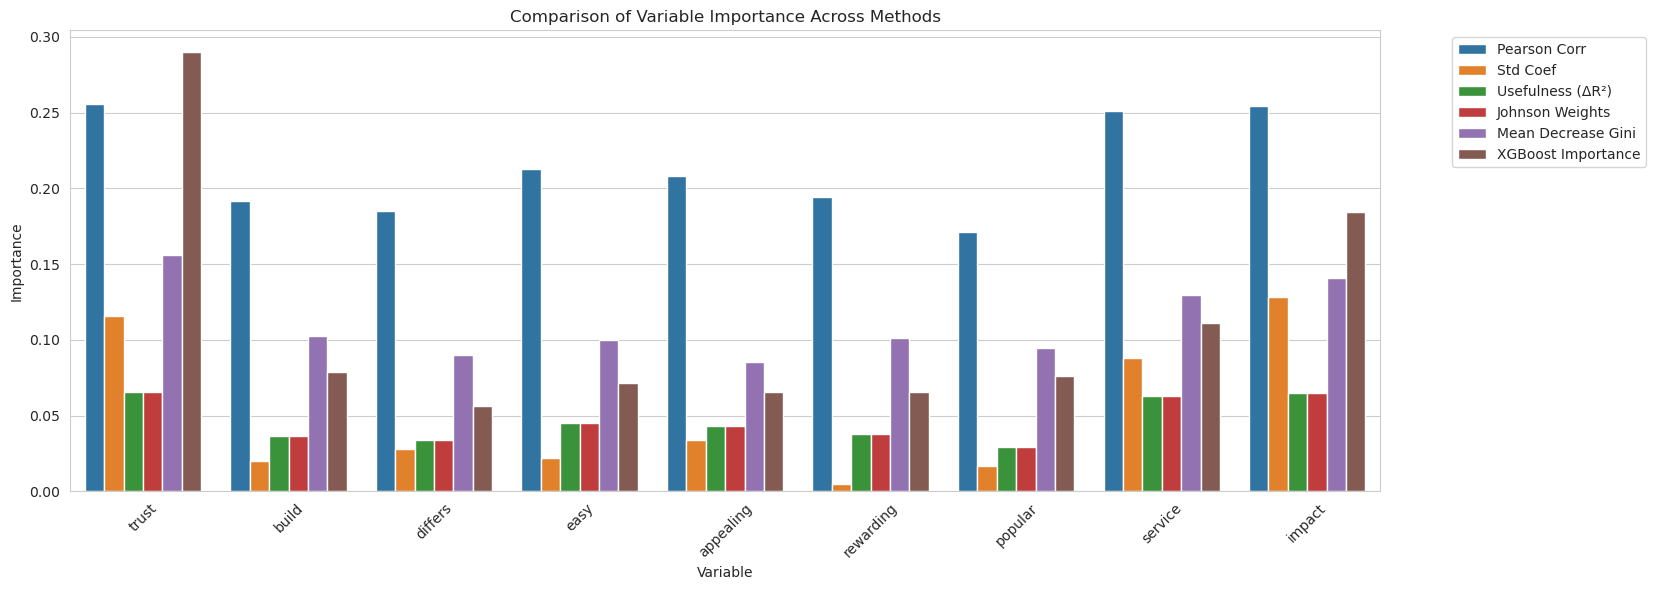

In [25]:


# Set plot size and style
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Create the grouped bar plot
sns.barplot(data=plot_df, x="Variable", y="Importance", hue="Method")

plt.xticks(rotation=45)
plt.title("Comparison of Variable Importance Across Methods")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


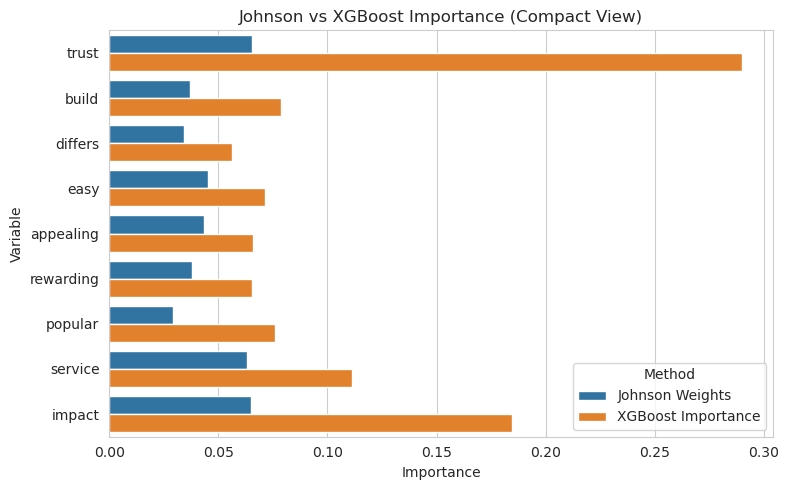

In [29]:
# Add XGBoost importance column directly into the results_df
results_df["XGBoost Importance"] = xgb_model.feature_importances_
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
xgb_model.fit(X, y)
import seaborn as sns
import matplotlib.pyplot as plt

# Compare Johnson vs XGBoost only
plot_subset = results_df[["Variable", "Johnson Weights", "XGBoost Importance"]]
plot_subset_melted = plot_subset.melt(id_vars="Variable", 
                                      var_name="Method", 
                                      value_name="Importance")

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
sns.barplot(data=plot_subset_melted, x="Importance", y="Variable", hue="Method")

plt.title("Johnson vs XGBoost Importance (Compact View)")
plt.tight_layout()
plt.show()
